# !WIP

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk
import tessreduce as tr

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Load Coinciding SPT Flares

In [3]:
coinciding_flares_df = pd.read_pickle('spt_tess_candidates.pkl')
coinciding_flares_df

,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


Some systems selected from Guns 2021 - Lightkurve

7 - WISE J025531.87-570252.3 | TIC207138379 | SPT-SV J025532.4-570257

6 - CC ERI | TIC142206123

8 - UCAC3 53-724 | TIC425937691

In [ ]:
for i, flare in coinciding_flares_df.iterrows():
    if (i == 0 or i == 2 or i == 3): continue
    print(i, '-', flare['TIC'])
    ra = flare['ra']
    if ra < 0: ra += 360
    dec = flare['dec']
    sectors = flare['sectors']
    tess_obs = tr.tessreduce(ra= ra, dec= dec, sector = sectors[0])
    # tess_obs.reduce()

    tess_obs.to_flux()
    lc = tess_obs.lc
    lc.shape
    plt.plot(lc[0], lc[1])

    # print("Pickling")
    # dbfile = open(f'{flare["TIC"]}_TR_LC', 'ab')
    # pickle.dump(lc, dbfile)
    # dbfile.close()

    # print("Verifying Pickle")
    # dbfile = open(f'{flare["TIC"]}_TR_LC', 'rb')
    # lc = pickle.load(dbfile)
    # dbfile.close()
    # plt.plot(lc[0], lc[1])

# Mixed TESSReduce-Custom LC Alg

ZP and ___ from TESSReduce

In [12]:
sys = coinciding_flares_df.iloc[0]
TIC = sys['TIC']
ra = sys['ra']
# if ra < 0: ra +=360
dec = sys['dec']
sectors = sys['sectors']
TR = tr.tessreduce(ra= ra, dec= dec, sector= sectors[0], plot= True, diagnostic_plot= True, diff= False)

getting TPF from TESScut


ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [ ]:
print(TIC)
TR.zp

In [ ]:
TR.to_flux()
lc = TR.lc
lc.shape
plt.plot(lc[0], lc[1])
(lc[0][1]-lc[0][0])*24*3600

In [ ]:
TR.tpf.plot()

<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>


NameError: name 'TR' is not defined

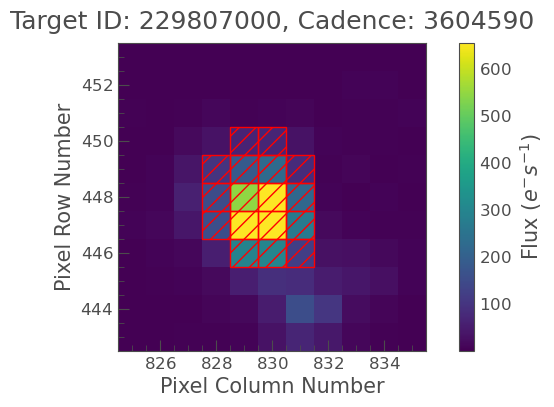

In [5]:
obj = lk.search_targetpixelfile(TIC, mission= 'TESS', sector= sectors[0], exptime= 'fast')
if len(obj) == 0: obj = lk.search_targetpixelfile(TIC, mission= 'TESS', sector= sectors[0], exptime= 'short')
if len(obj) == 0: obj = lk.search_targetpixelfile(TIC, mission= 'TESS', sector= sectors[0])
# if nothing else use TESSReduce result. For example TIC 279... only has FFIs which are actually higher cadence than the QLP lightcurve
flare_obs = obj[0].download()
print(type(flare_obs))
# print(flare_obs.author)
# print(flare_obs.meta)

flare_obs.plot(aperture_mask=flare_obs.pipeline_mask)
lc = flare_obs.extract_aperture_photometry()
lc_zp = lc['flux'] * 10**((TR.zp-16.4)/-2.5)
time = lc['time'].utc.mjd
print(type(lc['flux'].value))
f, ax = plt.subplots(1,1,figsize= (8,5))
ax.plot(time,lc_zp.value, label= 'mjy')
ax.plot(time, lc['flux'].value, label= 'e-/s')

cadence = int((time[1] - time[0])*24*3600)
print("exptime:", cadence, 's')


# target_mask = flare_obs.create_threshold_mask(threshold=10, reference_pixel='center')
# flare_obs.plot(aperture_mask=target_mask, mask_color='r');
# lc = flare_obs.to_lightcurve(aperture_mask=target_mask)
# lc_zp = lc[1] * 10**((TR.zp-16.4)/-2.5)
# plt.plot(???)

Lightcurve auto aperture may be too small as it has notably lower counts than TESSReduce

In [11]:
obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= sectors[0], exptime= 'fast')
if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= sectors[0], exptime= 'short')
if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= sectors[0])
flare_obs = obj[0].download()
print(flare_obs.author)
# print(flare_obs.meta)

qual = flare_obs.quality.value
time_tdb = Time(flare_obs.time.value[qual == 0], format= flare_obs.time.format, scale= flare_obs.time.scale)
time = time_tdb.utc.mjd
cadence = int((time[1] - time[0])*24*3600)
print("exptime:", cadence, 's')
sap_flux = np.array(flare_obs.sap_flux.value)[qual == 0]

print(flare_obs.sap_flux)

sap_flux = sap_flux * 10**(-0.4*(TR.zp-16.4))

plt.scatter(time, sap_flux)

SPOC
exptime: 20 s
[6333.4004 6324.1313 6361.254  ... 6462.4995 6411.3765 6537.4136] electron / s


NameError: name 'TR' is not defined